# Vision Transformers
In 2021, there was a significant development in the field of computer vision when it was demonstrated that the Transformer architecture, originally designed for natural language processing (NLP), could also be effectively applied to image classification tasks. This approach is known as the Vision Transformer, or ViT.

The ViT model operates by breaking down an image into fixed-size patches, similar to the way words are treated as tokens in NLP tasks. These image patches are then linearly embedded, position embeddings are incorporated to convey spatial information, and the resulting sequence of vectors is passed through a standard Transformer encoder. To perform image classification, an MLP is added on top of the Transformer to make the final classification predictions. This innovative approach has demonstrated remarkable results in image classification tasks.

# Import, Costants and Installation
In order to utilize the Keras-provided Vision Transformer library, it is essential to install certain packages.

In [ ]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.3/612.3 kB 13.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
import imutils
from tqdm import tqdm
from google.colab import drive
import tensorflow_addons as tfa
from vit_keras import vit
from keras.utils import plot_model

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Connection to Google Drive

In [ ]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%run "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/Utils.ipynb"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will also handle the downloading and extraction of the dataset from the Google Drive folder.

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-split.zip" -d '/'

# Hardware Accelerator test
Initially, it's essential to verify if hardware acceleration is enabled, as training a CNN on a CPU might be impractical.

In [ ]:
#check hardware acceleration
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Dataset loading

In [ ]:
train_ds, val_ds, test_ds = load_data_splits(IMAGE_SIZE, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


# Vision Transformer built from scratch
We start by configuring the hyperparameters. We will employ the Adam optimizer with weight decay. Given a patch size of 14, we will have 256 patches on our 224x224 image. The model will consist of 8 transformer layers and utilize 4 heads for the MultiHead Attention layer.

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
patch_size = 14  # Size of the patches to be extract from the input images
num_patches = (IMAGE_HEIGHT // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [512, 256]  # Size of the dense layers of the final classifier

## Patch visualization
As mentioned earlier, the Vision Transformer operates on image patches. To facilitate this, we must define the layer responsible for extracting patches from the input image.

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size
        })
        return config

We will proceed to illustrate the process of extracting patches from an image containing "all" cell types.

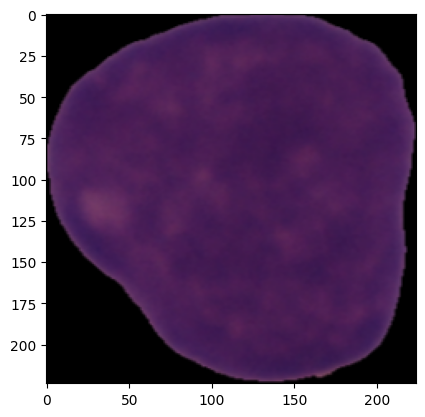

/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-cleaned/test_set/all/UID_47_7_1_all.bmp


In [ ]:
#all
first_image_all = os.listdir('/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-cleaned/test_set/all')[1]
img_path_all = '/content/drive/MyDrive/Colab Notebooks/B-CellLymphoblastsClassification/dataset-cleaned/test_set/all/' + first_image_all
# We preprocess the image into a 4D tensor (adding batch dimension)
img = image.load_img(img_path_all, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
img_tensor_all = image.img_to_array(img)
img_tensor_all = np.expand_dims(img_tensor_all, axis=0) # add batch dimension
plt.imshow(img_tensor_all[0].astype('uint8'))
plt.show()
print(img_path_all)

Image size: 224 X 224
Patch size: 14 X 14
Patches per image: 256
Elements per patch: 588


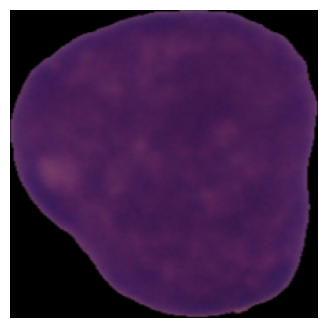

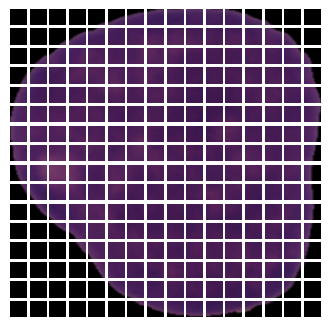

In [ ]:
plt.figure(figsize=(4, 4))
img = img_tensor_all[0]
plt.imshow(img.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=IMAGE_SIZE
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {IMAGE_HEIGHT} X {IMAGE_WIDTH}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Classification
We will define the function to create the MLP networks integrated into each transformer block, as well as the layer responsible for encoding the patches.

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.relu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding
        })
        return config

We will construct the model and proceed with the training process.

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    # Augment data.
    augmented = data_augmentation_layers(inputs)
    # Create patches
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    # Classify outputs.
    logits = layers.Dense(1)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits, name="VisionTransformerFromScratch")
    return model

In [ ]:
model = create_vit_classifier()
model.summary()

Model: "VisionTransformerFromScratch"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 patches_1 (Patches)         (None, None, 588)            0         ['sequential[0][0]']          
                                                                                                  
 patch_encoder (PatchEncode  (None, 256, 64)              54080     ['patches_1[0][0]']           
 r)                                                                    

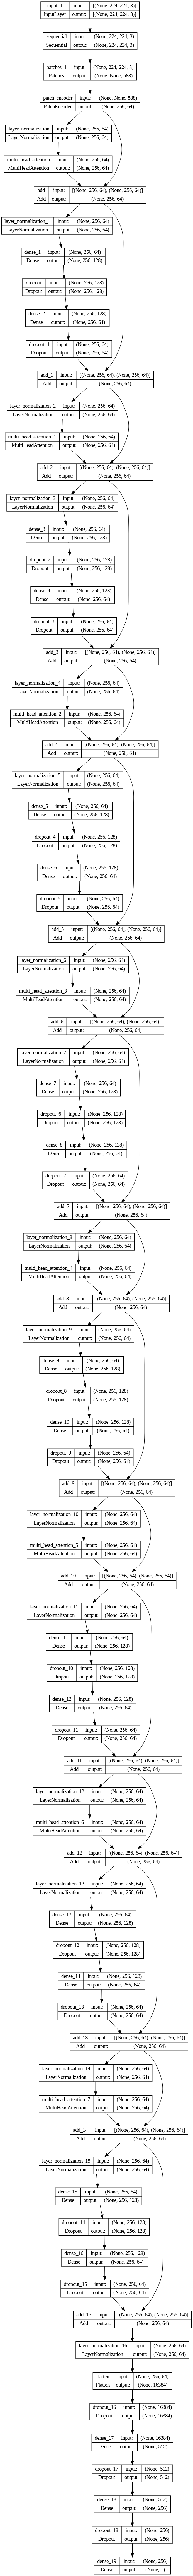

In [ ]:
plot_model(model, show_shapes = True)

In [ ]:
def run_experiment(model, epochs, patience):
    monitor="val_accuracy"
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = [keras.callbacks.EarlyStopping(monitor=monitor, patience=patience), # EarlyStopping to prevent overfitting
                           keras.callbacks.ModelCheckpoint(
                              checkpoint_filepath,
                              monitor=monitor,
                              save_best_only=True,
                              save_weights_only=True,
                          )]

    history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    callbacks=checkpoint_callback)

    model.load_weights(checkpoint_filepath)


    return history



Epoch 1/50
100/100 [==============================] - 42s 297ms/step - loss: 1.2098 - accuracy: 0.5092 - val_loss: 0.6488 - val_accuracy: 0.6735
Epoch 2/50
100/100 [==============================] - 28s 272ms/step - loss: 0.7054 - accuracy: 0.4975 - val_loss: 0.6957 - val_accuracy: 0.6735
Epoch 3/50
100/100 [==============================] - 28s 271ms/step - loss: 0.6936 - accuracy: 0.5002 - val_loss: 0.6942 - val_accuracy: 0.6735
Epoch 4/50
100/100 [==============================] - 27s 265ms/step - loss: 0.6932 - accuracy: 0.5006 - val_loss: 0.6938 - val_accuracy: 0.6735
Epoch 5/50
100/100 [==============================] - 28s 273ms/step - loss: 0.6928 - accuracy: 0.5000 - val_loss: 0.6532 - val_accuracy: 0.6735
Epoch 6/50
100/100 [==============================] - 28s 274ms/step - loss: 0.6945 - accuracy: 0.5000 - val_loss: 0.6971 - val_accuracy: 0.6735


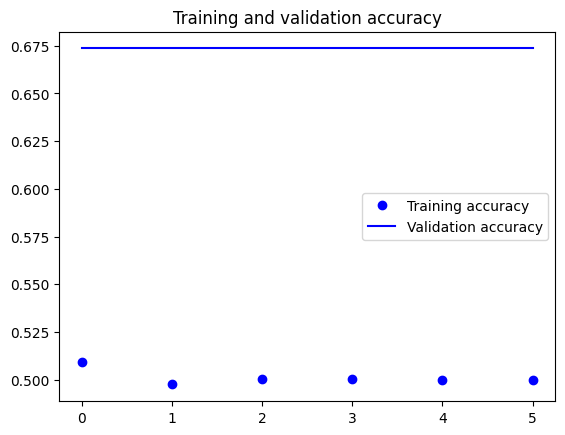

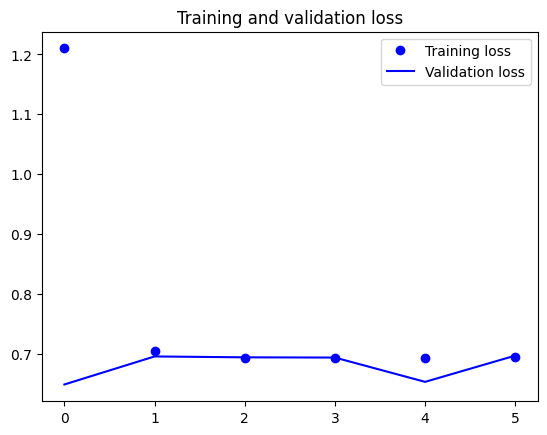

In [ ]:
history = run_experiment(model, 50, 5)
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 7s 175ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.6746    0.9111    0.7752      1463
         hem     0.1720    0.0403    0.0653       670

    accuracy                         0.6376      2133
   macro avg     0.4233    0.4757    0.4203      2133
weighted avg     0.5167    0.6376    0.5522      2133



34/34 [==============================] - 6s 172ms/step


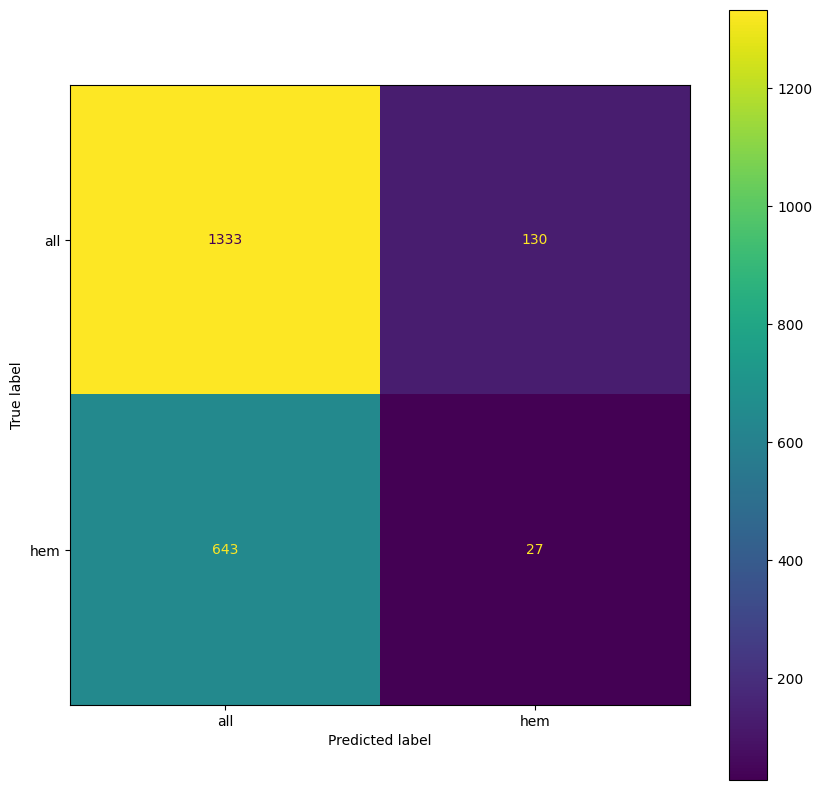

In [ ]:
plot_confusionmatrix(model, test_ds)

# Pretrained Vision Transformer
We are going to conduct some experiments involving a MLP built on top of a pre-trained Vision Transformer.

## Base Model Loading
The first step is to download the Vit-B32 model, which will serve as the foundation for constructing a Cells Classifier using this transformer.

In [ ]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'linear',
        pretrained = True,
        include_top = False,
        pretrained_top = False)

vit_model.summary()

353253686/353253686 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input  (None, 50, 768)           38400     
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 50, 768),         7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = vit_model(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="VisionTransformerb32_Dense256")
vit_model.trainable = False
model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "VisionTransformerb32_Dense256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                     

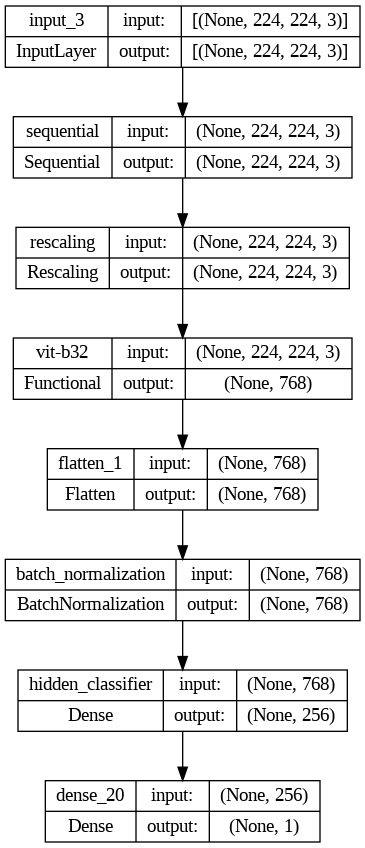

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.5754 - accuracy: 0.7112
Epoch 1: val_loss improved from inf to 0.47713, saving model to /content/model/VisionTransformerb32_Dense256.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 62s 418ms/step - loss: 0.5754 - accuracy: 0.7112 - val_loss: 0.4771 - val_accuracy: 0.7692
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.7472
Epoch 2: val_loss did not improve from 0.47713
100/100 [==============================] - 39s 385ms/step - loss: 0.5134 - accuracy: 0.7472 - val_loss: 0.5336 - val_accuracy: 0.7294
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4858 - accuracy: 0.7620
Epoch 3: val_loss improved from 0.47713 to 0.42904, saving model to /content/model/VisionTransformerb32_Dense256.h5
100/100 [==============================] - 39s 380ms/step - loss: 0.4858 - accuracy: 0.7620 - val_loss: 0.4290 - val_accuracy: 0.8007
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.4770 - accuracy: 0.7688
Epoch 4: val_loss did not improve from 0.42904
100/100 [==============================] - 38s 368ms/step - loss: 0.4770 - accuracy: 0.7688 - val_lo

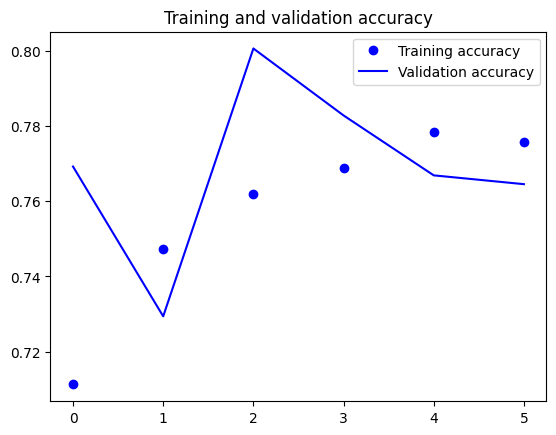

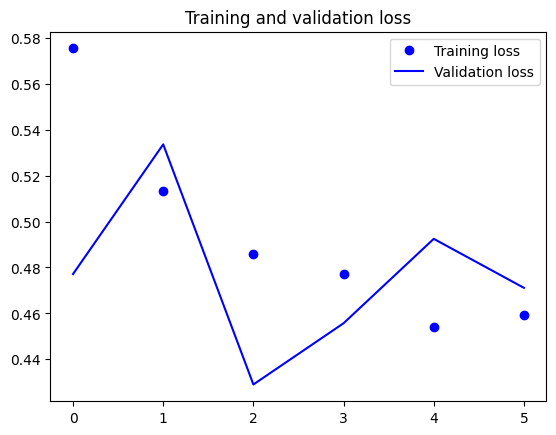

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 11s 231ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8515    0.8544    0.8530      1463
         hem     0.6797    0.6746    0.6772       670

    accuracy                         0.7979      2133
   macro avg     0.7656    0.7645    0.7651      2133
weighted avg     0.7975    0.7979    0.7977      2133



34/34 [==============================] - 8s 235ms/step


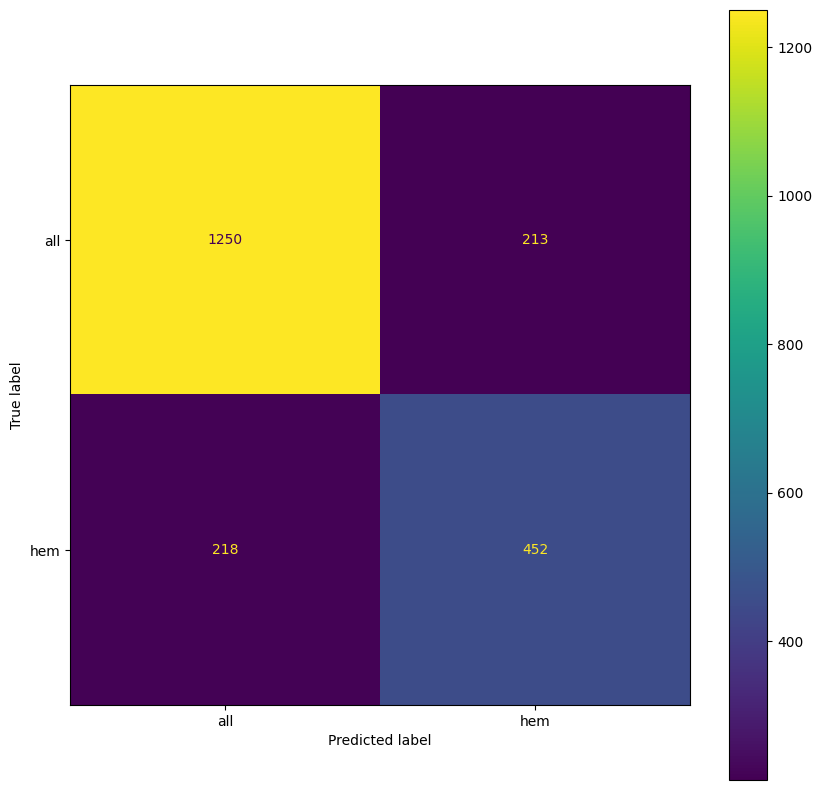

In [ ]:
plot_confusionmatrix(model, test_ds)

##256 Dense Neurons, Dropout
We try to add Dropout with a 0.3 rate.

In [ ]:
vit_model = vit.vit_b32(image_size = IMAGE_SIZE, activation = 'linear', pretrained = True, include_top = False, pretrained_top = False)
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = vit_model(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="VisionTransformerb32_Dense256_Dropout03")
model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "VisionTransformerb32_Dense256_Dropout03"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_2 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 768)               3072      
 chNormalization)                                                
                           

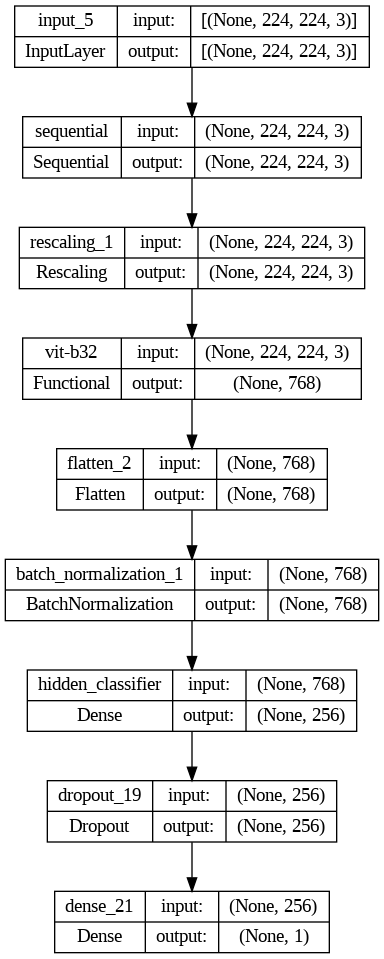

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.5768
Epoch 1: val_loss improved from inf to 0.63423, saving model to /content/model/VisionTransformerb32_Dense256_Dropout03.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 142s 899ms/step - loss: 0.7645 - accuracy: 0.5768 - val_loss: 0.6342 - val_accuracy: 0.6735
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.6314 - accuracy: 0.6828
Epoch 2: val_loss did not improve from 0.63423
100/100 [==============================] - 81s 792ms/step - loss: 0.6314 - accuracy: 0.6828 - val_loss: 1.9412 - val_accuracy: 0.3265
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.5613 - accuracy: 0.7219
Epoch 3: val_loss improved from 0.63423 to 0.49228, saving model to /content/model/VisionTransformerb32_Dense256_Dropout03.h5
100/100 [==============================] - 85s 842ms/step - loss: 0.5613 - accuracy: 0.7219 - val_loss: 0.4923 - val_accuracy: 0.7655
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.7611
Epoch 4: val_loss did not improve from 0.49228
100/100 [==============================] - 80s 790ms/step - loss: 0.5054 - accuracy: 0.76

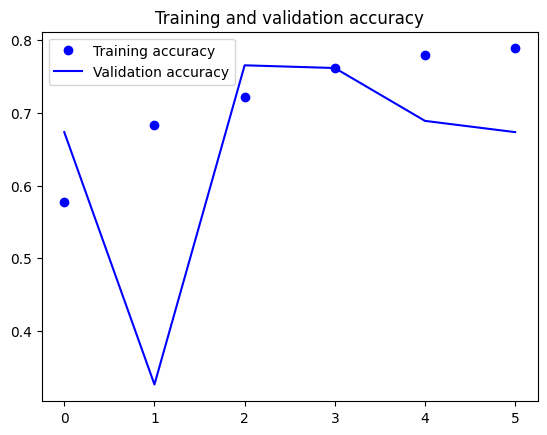

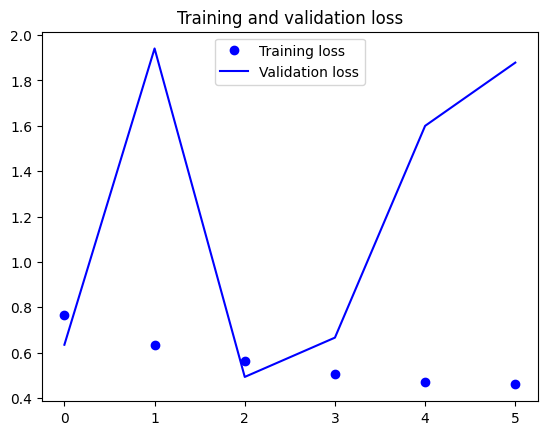

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 12s 250ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.7921    0.9296    0.8553      1463
         hem     0.7524    0.4672    0.5764       670

    accuracy                         0.7843      2133
   macro avg     0.7722    0.6984    0.7159      2133
weighted avg     0.7796    0.7843    0.7677      2133



34/34 [==============================] - 8s 236ms/step


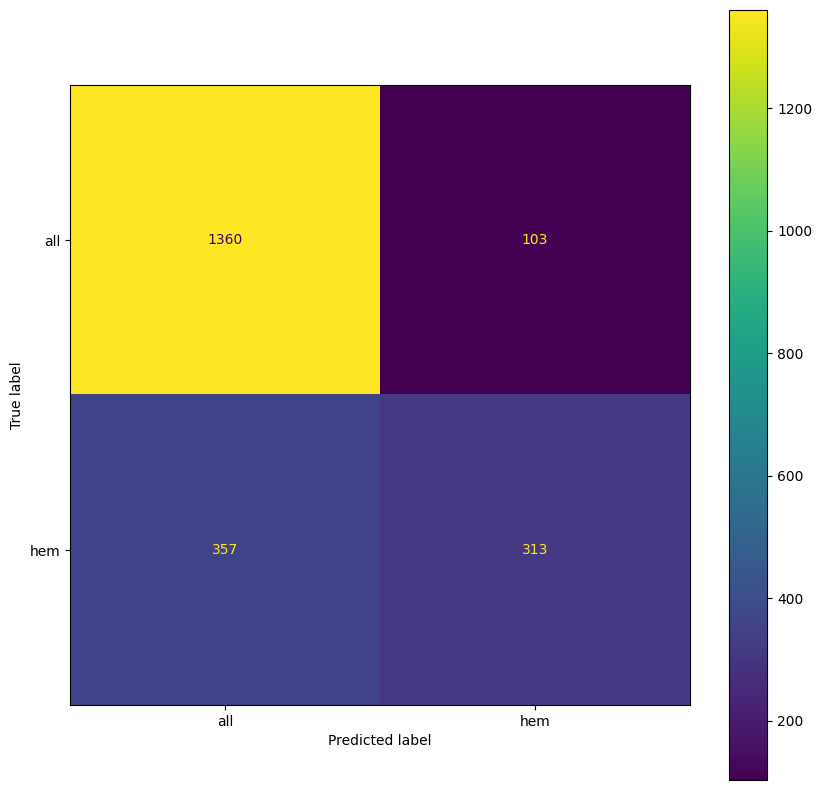

In [ ]:
plot_confusionmatrix(model, test_ds)

##First the training of the MLP network and then the fine tuning of the transformer.
In CNN it's common to start by freezing the base network, training the MLP network, and then, in a subsequent phase, fine-tuning the entire network. We would like to explore whether a similar procedure is effective for Vision Transformers.

In [ ]:
vit_model = vit.vit_b32(image_size = IMAGE_SIZE, activation = 'linear', pretrained = True, include_top = False, pretrained_top = False)
vit_model.trainable = False
vit_model.summary()

Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape_2 (Reshape)         (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input  (None, 50, 768)           38400     
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 50, 768),         7087872   
  (TransformerBlock)          (None, 12, None, None)       

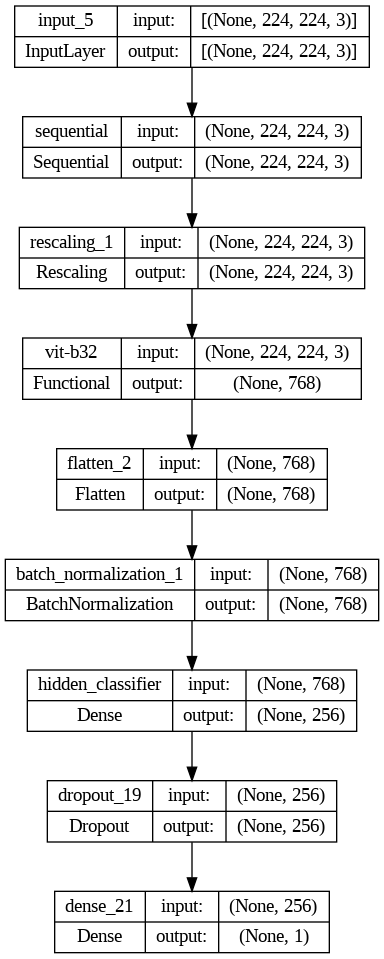

In [ ]:
plot_model(model, show_shapes = True)

### MLP Training
We will carry out this experiment using the previously mentioned model, but without the dropout layer.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = data_augmentation_layers(inputs)
x = layers.Rescaling(1./255)(x)
x = vit_model(x)
x = layers.Flatten()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu', name='hidden_classifier') (x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="VisionTransformerb32_Dense256_Freezed")
model = compile_model(model, loss="binary_crossentropy")
model.summary()

Model: "VisionTransformerb32_Dense256_Freezed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 768)               3072      
 chNormalization)                                                
                             

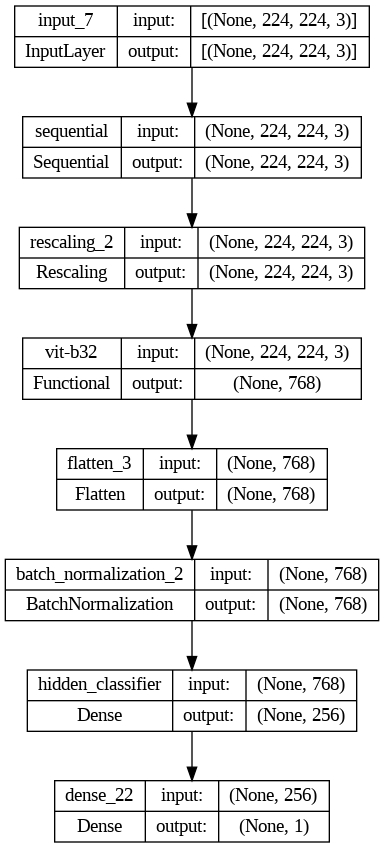

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.6964
Epoch 1: val_loss improved from inf to 0.57680, saving model to /content/model/VisionTransformerb32_Dense256_Freezed.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 62s 429ms/step - loss: 0.5947 - accuracy: 0.6964 - val_loss: 0.5768 - val_accuracy: 0.6740
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5077 - accuracy: 0.7505
Epoch 2: val_loss improved from 0.57680 to 0.49452, saving model to /content/model/VisionTransformerb32_Dense256_Freezed.h5
100/100 [==============================] - 40s 387ms/step - loss: 0.5077 - accuracy: 0.7505 - val_loss: 0.4945 - val_accuracy: 0.7613
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4969 - accuracy: 0.7505
Epoch 3: val_loss did not improve from 0.49452
100/100 [==============================] - 39s 368ms/step - loss: 0.4969 - accuracy: 0.7505 - val_loss: 0.5318 - val_accuracy: 0.7181
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.7584
Epoch 4: val_loss did not improve from 0.49452
100/100 [==============================] - 38s 373ms/step - loss: 0.4822 - accuracy: 0.7584 

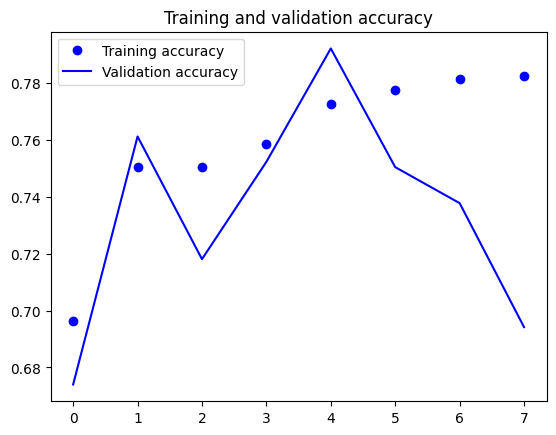

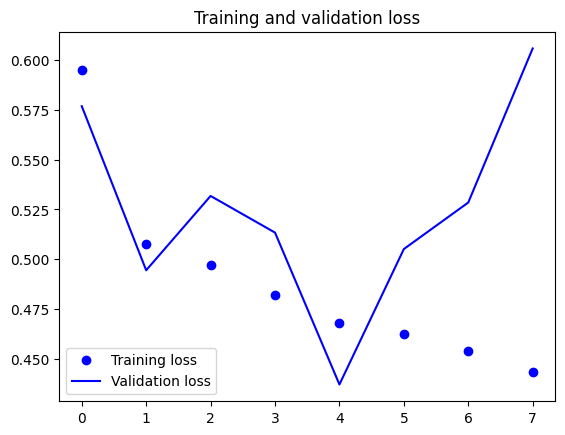

In [ ]:
model, history = run_model(model, model.name, train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 16s 233ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.8691    0.7895    0.8274      1463
         hem     0.6169    0.7403    0.6730       670

    accuracy                         0.7740      2133
   macro avg     0.7430    0.7649    0.7502      2133
weighted avg     0.7899    0.7740    0.7789      2133



34/34 [==============================] - 8s 238ms/step


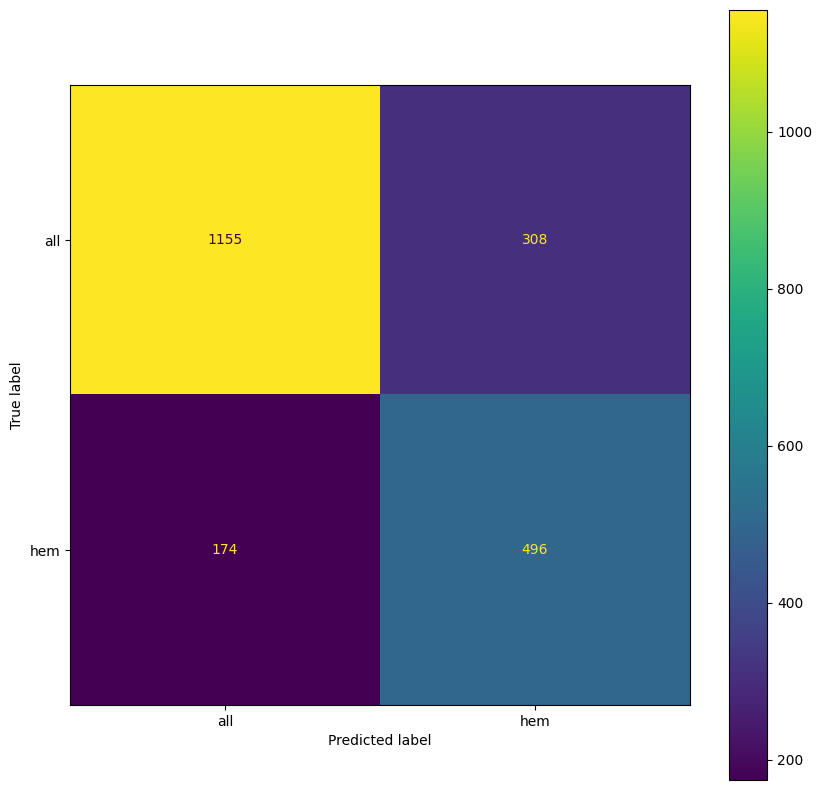

In [ ]:
plot_confusionmatrix(model, test_ds)

### Vision Transformer Fine Tuning
Next, we will unfreeze the base model and proceed with the fine tuning process.

In [ ]:
model.get_layer("vit-b32").trainable = True
model = compile_model(model, loss="binary_crossentropy", learning_rate=0.0001)
model.summary()

Model: "VisionTransformerb32_Dense256_Freezed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_3 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 768)               3072      
 chNormalization)                                                
                             

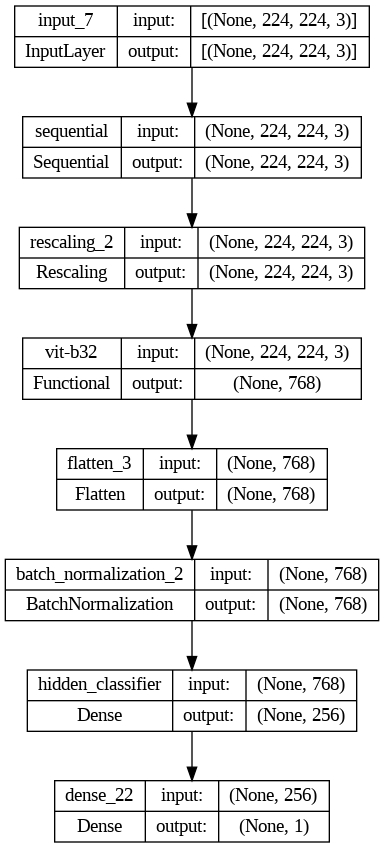

In [ ]:
plot_model(model, show_shapes = True)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.4504 - accuracy: 0.7869
Epoch 1: val_loss improved from inf to 0.32488, saving model to /content/model/VisionTransformerb32_Dense256_Finetuning.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 144s 873ms/step - loss: 0.4504 - accuracy: 0.7869 - val_loss: 0.3249 - val_accuracy: 0.8541
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.3562 - accuracy: 0.8441
Epoch 2: val_loss did not improve from 0.32488
100/100 [==============================] - 80s 779ms/step - loss: 0.3562 - accuracy: 0.8441 - val_loss: 0.5846 - val_accuracy: 0.8279
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.2986 - accuracy: 0.8751
Epoch 3: val_loss did not improve from 0.32488
100/100 [==============================] - 79s 781ms/step - loss: 0.2986 - accuracy: 0.8751 - val_loss: 1.7344 - val_accuracy: 0.5488
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.8940
Epoch 4: val_loss did not improve from 0.32488
100/100 [==============================] - 79s 784ms/step - loss: 0.2535 - accuracy: 0.8940 - val_loss: 0.5577 - val_accuracy: 0.8068
Saving /content/drive/MyDrive/Cola

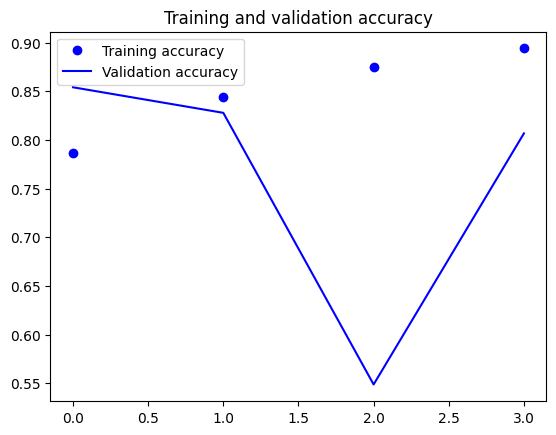

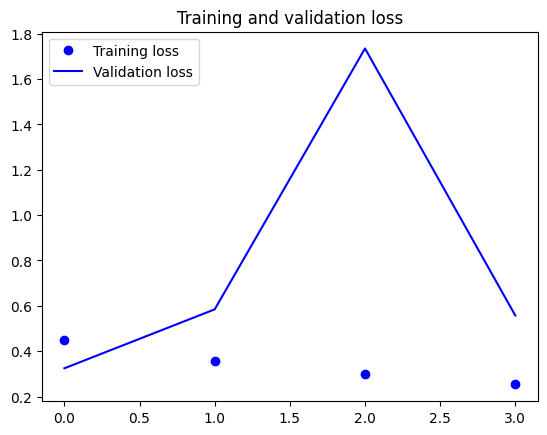

In [ ]:
model, history = run_model(model, "VisionTransformerb32_Dense256_Finetuning", train_ds, val_ds, 50, patience=3, monitor='val_loss')
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, test_ds)

34/34 [==============================] - 12s 245ms/step
Classification report:
              precision    recall  f1-score   support

         all     0.9133    0.8859    0.8994      1463
         hem     0.7661    0.8164    0.7905       670

    accuracy                         0.8640      2133
   macro avg     0.8397    0.8511    0.8449      2133
weighted avg     0.8671    0.8640    0.8652      2133



34/34 [==============================] - 9s 249ms/step


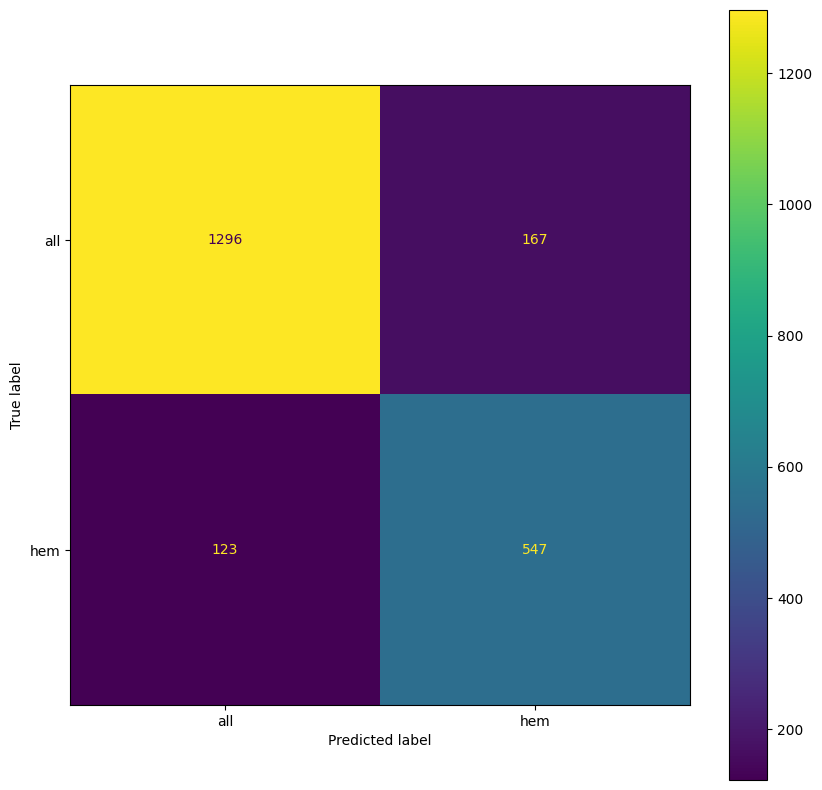

In [ ]:
plot_confusionmatrix(model, test_ds)